In [2]:
%%capture 

!pip install snowflake-connector-python

In [3]:
%%capture 

! pip install snowflake-sqlalchemy

In [4]:
%%capture

! pip install xgboost

In [5]:
import os
import pickle
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import metrics

import sqlalchemy
import snowflake.connector
from sqlalchemy import create_engine,text
from snowflake.sqlalchemy import *

import xgboost
from datetime import datetime, timedelta
import time  
import pytz    
tz_NY = pytz.timezone('America/New_York')

import snowflake_creds

import warnings
warnings.filterwarnings('ignore')

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/snowflake/connector/options.py:104: UserWarning: You have an incompatible version of 'pyarrow' installed (19.0.1), please install a version that adheres to: 'pyarrow<19.0.0; extra == "pandas"'
  warn_incompatible_dep(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [6]:
## creating the connection engine 
engine = create_engine(URL(
        account="HTVQIFU-LXB83489",
        user= snowflake_creds.USER_NAME,
        password= snowflake_creds.PASSWORD,
        role="ACCOUNTADMIN",
        warehouse="COMPUTE_WH",
        database="HEALTHDB",
        schema="HEALTHSCHEMA"
    ))

In [9]:
query = """

WITH BASE AS (

    SELECT CASE_ID,
           COALESCE(HOSPITAL_CODE,0) AS HOSPITAL_CODE,
           COALESCE(HOSPITAL_TYPE_CODE,'None') AS HOSPITAL_TYPE_CODE,
           COALESCE(CITY_CODE_HOSPITAL,0) AS CITY_CODE_HOSPITAL,
           COALESCE(HOSPITAL_REGION_CODE,'None') AS HOSPITAL_REGION_CODE,
           COALESCE(AVAILABLE_EXTRA_ROOMS_IN_HOSPITAL,0) AS AVAILABLE_EXTRA_ROOMS_IN_HOSPITAL,
           COALESCE(DEPARTMENT,'None') AS DEPARTMENT,
           COALESCE(WARD_TYPE,'None') AS WARD_TYPE,
           COALESCE(WARD_FACILITY_CODE,'None') AS WARD_FACILITY_CODE,
           COALESCE(BED_GRADE,0) AS BED_GRADE,
           PATIENTID,
           COALESCE(CITY_CODE_PATIENT,0) AS CITY_CODE_PATIENT,
           COALESCE(TYPE_OF_ADMISSION,'None') AS TYPE_OF_ADMISSION,
           COALESCE(SEVERITY_OF_ILLNESS,'Minor') AS SEVERITY_OF_ILLNESS,
           COALESCE(VISITORS_WITH_PATIENT,0) AS VISITORS_WITH_PATIENT,
           COALESCE(AGE,'None') AS AGE,
           COALESCE(ADMISSION_DEPOSIT,0) AS ADMISSION_DEPOSIT,
           ADMISSION_DATE,
           DISCHARGE_DATE

    FROM HEALTHDB.HEALTHSCHEMA.HEALTH_DATA

),
BASE_WITH_FEATURES AS (

    SELECT *,
            MONTHNAME(ADMISSION_DATE) AS ADMISSION_MONTH,
            DAYNAME(ADMISSION_DATE) AS ADMISSION_DAY,    
            CONCAT(TYPE_OF_ADMISSION,'-',SEVERITY_OF_ILLNESS) AS ADMISSION_ILLNESS,
            CONCAT(SEVERITY_OF_ILLNESS,'-',BED_GRADE) AS ILLNESS_BEDGRADE,
            CONCAT(DEPARTMENT,'-',SEVERITY_OF_ILLNESS) AS DEPARTMENT_ILLNESS,
            DATEDIFF(day,ADMISSION_DATE,DISCHARGE_DATE) AS LOS
    FROM BASE 

)    

SELECT * FROM BASE_WITH_FEATURES

"""

In [10]:
with engine.connect() as conn:
    data=pd.DataFrame(pd.read_sql(text(query),conn))
    data.columns=[col.upper() for col in data.columns.tolist()]

In [11]:
print(data.shape)
data.head()

(236704, 25)


,CASE_ID,HOSPITAL_CODE,HOSPITAL_TYPE_CODE,CITY_CODE_HOSPITAL,HOSPITAL_REGION_CODE,AVAILABLE_EXTRA_ROOMS_IN_HOSPITAL,DEPARTMENT,WARD_TYPE,WARD_FACILITY_CODE,BED_GRADE,PATIENTID,CITY_CODE_PATIENT,TYPE_OF_ADMISSION,SEVERITY_OF_ILLNESS,VISITORS_WITH_PATIENT,AGE,ADMISSION_DEPOSIT,ADMISSION_DATE,DISCHARGE_DATE,ADMISSION_MONTH,ADMISSION_DAY,ADMISSION_ILLNESS,ILLNESS_BEDGRADE,DEPARTMENT_ILLNESS,LOS
0,1,8,c,3,Z,3,radiotherapy,R,F,2,31397,7,Emergency,Extreme,2,51-60,4911,2022-08-10,2022-08-20,Aug,Wed,Emergency-Extreme,Extreme-2,radiotherapy-Extreme,10
1,3,10,e,1,X,2,anesthesia,S,E,2,31397,7,Trauma,Extreme,2,51-60,4745,2022-09-09,2022-10-19,Sep,Fri,Trauma-Extreme,Extreme-2,anesthesia-Extreme,40
2,4,26,b,2,Y,2,radiotherapy,R,D,2,31397,7,Trauma,Extreme,2,51-60,7272,2022-09-22,2022-11-11,Sep,Thu,Trauma-Extreme,Extreme-2,radiotherapy-Extreme,50
3,5,26,b,2,Y,2,radiotherapy,S,D,2,31397,7,Trauma,Extreme,2,51-60,5558,2022-11-02,2022-12-22,Nov,Wed,Trauma-Extreme,Extreme-2,radiotherapy-Extreme,50
4,6,23,a,6,X,2,anesthesia,S,F,2,31397,7,Trauma,Extreme,2,51-60,4449,2022-09-16,2022-10-06,Sep,Fri,Trauma-Extreme,Extreme-2,anesthesia-Extreme,20


### Preprocessing

- Dropping unwanted columns
- One-Hot encoding categorical columns
- Set the CASE_ID as index

NOTE: Save the preprocessing steps for later use during the scoring process


In [12]:
cols_to_drop = ['HOSPITAL_CODE','PATIENTID','ADMISSION_DATE','DISCHARGE_DATE']

In [13]:
data_pre = data.copy()

In [14]:
# Dropping columns

print("Before dropping: ", data_pre.shape)
data_pre = data_pre.drop(cols_to_drop,axis=1)
print("After dropping: ", data_pre.shape)

Before dropping:  (236704, 25)
After dropping:  (236704, 21)


In [15]:
data_pre.set_index('CASE_ID',inplace=True)

In [16]:
data_pre.head(3)

,HOSPITAL_TYPE_CODE,CITY_CODE_HOSPITAL,HOSPITAL_REGION_CODE,AVAILABLE_EXTRA_ROOMS_IN_HOSPITAL,DEPARTMENT,WARD_TYPE,WARD_FACILITY_CODE,BED_GRADE,CITY_CODE_PATIENT,TYPE_OF_ADMISSION,SEVERITY_OF_ILLNESS,VISITORS_WITH_PATIENT,AGE,ADMISSION_DEPOSIT,ADMISSION_MONTH,ADMISSION_DAY,ADMISSION_ILLNESS,ILLNESS_BEDGRADE,DEPARTMENT_ILLNESS,LOS
CASE_ID,,,,,,,,,,,,,,,,,,,,
1,c,3,Z,3,radiotherapy,R,F,2,7,Emergency,Extreme,2,51-60,4911,Aug,Wed,Emergency-Extreme,Extreme-2,radiotherapy-Extreme,10
3,e,1,X,2,anesthesia,S,E,2,7,Trauma,Extreme,2,51-60,4745,Sep,Fri,Trauma-Extreme,Extreme-2,anesthesia-Extreme,40
4,b,2,Y,2,radiotherapy,R,D,2,7,Trauma,Extreme,2,51-60,7272,Sep,Thu,Trauma-Extreme,Extreme-2,radiotherapy-Extreme,50


In [17]:
# Fixing the data types issue
num_columns = ['AVAILABLE_EXTRA_ROOMS_IN_HOSPITAL','VISITORS_WITH_PATIENT','ADMISSION_DEPOSIT','LOS']
cat_columns = [col for col in data_pre.columns.tolist() if col not in num_columns]

In [18]:
data_pre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 236704 entries, 1 to 255883
Data columns (total 20 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   HOSPITAL_TYPE_CODE                 236704 non-null  object
 1   CITY_CODE_HOSPITAL                 236704 non-null  int64 
 2   HOSPITAL_REGION_CODE               236704 non-null  object
 3   AVAILABLE_EXTRA_ROOMS_IN_HOSPITAL  236704 non-null  int64 
 4   DEPARTMENT                         236704 non-null  object
 5   WARD_TYPE                          236704 non-null  object
 6   WARD_FACILITY_CODE                 236704 non-null  object
 7   BED_GRADE                          236704 non-null  int64 
 8   CITY_CODE_PATIENT                  236704 non-null  int64 
 9   TYPE_OF_ADMISSION                  236704 non-null  object
 10  SEVERITY_OF_ILLNESS                236704 non-null  object
 11  VISITORS_WITH_PATIENT              236704 non-null  

In [19]:
for col in num_columns:
    data_pre[col]=data_pre[col].astype(int)
for col in cat_columns:
    data_pre[col]=data_pre[col].astype(object)

In [20]:
data_pre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 236704 entries, 1 to 255883
Data columns (total 20 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   HOSPITAL_TYPE_CODE                 236704 non-null  object
 1   CITY_CODE_HOSPITAL                 236704 non-null  object
 2   HOSPITAL_REGION_CODE               236704 non-null  object
 3   AVAILABLE_EXTRA_ROOMS_IN_HOSPITAL  236704 non-null  int64 
 4   DEPARTMENT                         236704 non-null  object
 5   WARD_TYPE                          236704 non-null  object
 6   WARD_FACILITY_CODE                 236704 non-null  object
 7   BED_GRADE                          236704 non-null  object
 8   CITY_CODE_PATIENT                  236704 non-null  object
 9   TYPE_OF_ADMISSION                  236704 non-null  object
 10  SEVERITY_OF_ILLNESS                236704 non-null  object
 11  VISITORS_WITH_PATIENT              236704 non-null  

In [21]:
# One-Hot Encoding
data_after_process = pd.get_dummies(data_pre)

In [22]:
print(data_after_process.shape)
data_after_process.head()

(236704, 150)


,AVAILABLE_EXTRA_ROOMS_IN_HOSPITAL,VISITORS_WITH_PATIENT,ADMISSION_DEPOSIT,LOS,HOSPITAL_TYPE_CODE_a,HOSPITAL_TYPE_CODE_b,HOSPITAL_TYPE_CODE_c,HOSPITAL_TYPE_CODE_d,HOSPITAL_TYPE_CODE_e,HOSPITAL_TYPE_CODE_f,HOSPITAL_TYPE_CODE_g,CITY_CODE_HOSPITAL_1,CITY_CODE_HOSPITAL_2,CITY_CODE_HOSPITAL_3,CITY_CODE_HOSPITAL_4,CITY_CODE_HOSPITAL_5,CITY_CODE_HOSPITAL_6,CITY_CODE_HOSPITAL_7,CITY_CODE_HOSPITAL_9,CITY_CODE_HOSPITAL_10,CITY_CODE_HOSPITAL_11,CITY_CODE_HOSPITAL_13,HOSPITAL_REGION_CODE_X,HOSPITAL_REGION_CODE_Y,HOSPITAL_REGION_CODE_Z,DEPARTMENT_TB & Chest disease,DEPARTMENT_anesthesia,DEPARTMENT_gynecology,DEPARTMENT_radiotherapy,DEPARTMENT_surgery,WARD_TYPE_P,WARD_TYPE_Q,WARD_TYPE_R,WARD_TYPE_S,WARD_TYPE_T,WARD_TYPE_U,WARD_FACILITY_CODE_A,WARD_FACILITY_CODE_B,WARD_FACILITY_CODE_C,WARD_FACILITY_CODE_D,WARD_FACILITY_CODE_E,WARD_FACILITY_CODE_F,BED_GRADE_0,BED_GRADE_1,BED_GRADE_2,BED_GRADE_3,BED_GRADE_4,CITY_CODE_PATIENT_0,CITY_CODE_PATIENT_1,CITY_CODE_PATIENT_2,CITY_CODE_PATIENT_3,CITY_CODE_PATIENT_4,CITY_CODE_PATIENT_5,CITY_CODE_PATIENT_6,CITY_CODE_PATIENT_7,CITY_CODE_PATIENT_8,CITY_CODE_PATIENT_9,CITY_CODE_PATIENT_10,CITY_CODE_PATIENT_11,CITY_CODE_PATIENT_12,CITY_CODE_PATIENT_13,CITY_CODE_PATIENT_14,CITY_CODE_PATIENT_15,CITY_CODE_PATIENT_16,CITY_CODE_PATIENT_18,CITY_CODE_PATIENT_19,CITY_CODE_PATIENT_20,CITY_CODE_PATIENT_21,CITY_CODE_PATIENT_22,CITY_CODE_PATIENT_23,CITY_CODE_PATIENT_24,CITY_CODE_PATIENT_25,CITY_CODE_PATIENT_26,CITY_CODE_PATIENT_27,CITY_CODE_PATIENT_28,CITY_CODE_PATIENT_29,CITY_CODE_PATIENT_30,CITY_CODE_PATIENT_31,CITY_CODE_PATIENT_32,CITY_CODE_PATIENT_33,CITY_CODE_PATIENT_34,CITY_CODE_PATIENT_35,CITY_CODE_PATIENT_36,CITY_CODE_PATIENT_37,TYPE_OF_ADMISSION_Emergency,TYPE_OF_ADMISSION_Trauma,TYPE_OF_ADMISSION_Urgent,SEVERITY_OF_ILLNESS_Extreme,SEVERITY_OF_ILLNESS_Minor,SEVERITY_OF_ILLNESS_Moderate,AGE_0-10,AGE_20-Nov,AGE_21-30,AGE_31-40,AGE_41-50,AGE_51-60,AGE_61-70,AGE_71-80,AGE_81-90,AGE_91-100,ADMISSION_MONTH_Aug,ADMISSION_MONTH_Nov,ADMISSION_MONTH_Oct,ADMISSION_MONTH_Sep,ADMISSION_DAY_Fri,ADMISSION_DAY_Mon,ADMISSION_DAY_Sat,ADMISSION_DAY_Sun,ADMISSION_DAY_Thu,ADMISSION_DAY_Tue,ADMISSION_DAY_Wed,ADMISSION_ILLNESS_Emergency-Extreme,ADMISSION_ILLNESS_Emergency-Minor,ADMISSION_ILLNESS_Emergency-Moderate,ADMISSION_ILLNESS_Trauma-Extreme,ADMISSION_ILLNESS_Trauma-Minor,ADMISSION_ILLNESS_Trauma-Moderate,ADMISSION_ILLNESS_Urgent-Extreme,ADMISSION_ILLNESS_Urgent-Minor,ADMISSION_ILLNESS_Urgent-Moderate,ILLNESS_BEDGRADE_Extreme-0,ILLNESS_BEDGRADE_Extreme-1,ILLNESS_BEDGRADE_Extreme-2,ILLNESS_BEDGRADE_Extreme-3,ILLNESS_BEDGRADE_Extreme-4,ILLNESS_BEDGRADE_Minor-0,ILLNESS_BEDGRADE_Minor-1,ILLNESS_BEDGRADE_Minor-2,ILLNESS_BEDGRADE_Minor-3,ILLNESS_BEDGRADE_Minor-4,ILLNESS_BEDGRADE_Moderate-0,ILLNESS_BEDGRADE_Moderate-1,ILLNESS_BEDGRADE_Moderate-2,ILLNESS_BEDGRADE_Moderate-3,ILLNESS_BEDGRADE_Moderate-4,DEPARTMENT_ILLNESS_TB & Chest disease-Extreme,DEPARTMENT_ILLNESS_TB & Chest disease-Minor,DEPARTMENT_ILLNESS_TB & Chest disease-Moderate,DEPARTMENT_ILLNESS_anesthesia-Extreme,DEPARTMENT_ILLNESS_anesthesia-Minor,DEPARTMENT_ILLNESS_anesthesia-Moderate,DEPARTMENT_ILLNESS_gynecology-Extreme,DEPARTMENT_ILLNESS_gynecology-Minor,DEPARTMENT_ILLNESS_gynecology-Moderate,DEPARTMENT_ILLNESS_radiotherapy-Extreme,DEPARTMENT_ILLNESS_radiotherapy-Minor,DEPARTMENT_ILLNESS_radiotherapy-Moderate,DEPARTMENT_ILLNESS_surgery-Extreme,DEPARTMENT_ILLNESS_surgery-Minor,DEPARTMENT_ILLNESS_surgery-Moderate
CASE_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,3,2,4911,10,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,2,2,4745,40,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,

In [23]:
%%writefile LOS_Preprocessing.py


import pandas as pd
import numpy as np

## Complete Preprocessing Steps
def preprocess_data(df):
    # Columns to drop
    cols_to_drop = ['HOSPITAL_CODE','PATIENTID','ADMISSION_DATE','DISCHARGE_DATE']
    df = df.drop(cols_to_drop,axis=1)
    
    # Setting the index
    df.set_index('CASE_ID',inplace=True)

    # Fixing the data types issue
    num_columns = ['AVAILABLE_EXTRA_ROOMS_IN_HOSPITAL','VISITORS_WITH_PATIENT','ADMISSION_DEPOSIT','LOS']
    cat_columns = [col for col in df.columns.tolist() if col not in num_columns]
    
    for col in cat_columns:
        df[col] = df[col].astype(object)    
    
    for col in num_columns:
        df[col] = df[col].astype(int)
    
    # One-Hot Encoding
    df_final = pd.get_dummies(df)    
    
    return df_final

Overwriting LOS_Preprocessing.py


### Feature Selection

In [24]:
df_final = data_after_process.copy()
print(df_final.shape)

(236704, 150)


In [25]:
# Creating Train and test split
from sklearn.model_selection import train_test_split

X = df_final.drop('LOS',axis=1)
Y = df_final[['LOS']]

x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.3,stratify=Y)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(165692, 149) (165692, 1)
(71012, 149) (71012, 1)


### 1. Decision Tree Selection

In [26]:
from sklearn.tree import DecisionTreeRegressor
dtree=DecisionTreeRegressor()
dtree.fit(x_train,y_train) 
dtree.score(x_train,y_train)

0.9999893173487946

In [27]:
# feature importance 
feat_imp=pd.DataFrame(zip(x_train.columns,dtree.feature_importances_),columns=['feature','imp']).sort_values(by='imp',ascending=False)
display(feat_imp[:20])

,feature,imp
1,VISITORS_WITH_PATIENT,0.186527
2,ADMISSION_DEPOSIT,0.159113
30,WARD_TYPE_Q,0.069661
0,AVAILABLE_EXTRA_ROOMS_IN_HOSPITAL,0.037133
100,ADMISSION_MONTH_Nov,0.033079
32,WARD_TYPE_S,0.015564
29,WARD_TYPE_P,0.013751
93,AGE_41-50,0.011903
92,AGE_31-40,0.011384
108,ADMISSION_DAY_Tue,0.011359


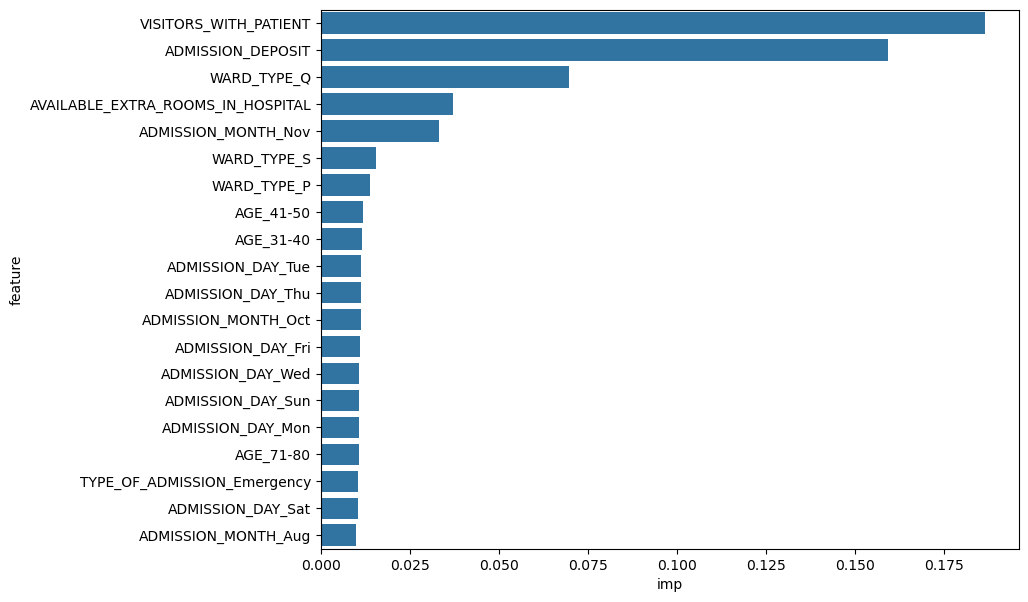

In [28]:
plt.figure(figsize=(9,7))
sns.barplot(y='feature',x='imp',data=feat_imp[:20],orient='h')
plt.show()

In [29]:
# Selecting features with atleast 1% importance value
display(feat_imp[feat_imp['imp']>=0.01])
final_features_dtree = feat_imp[feat_imp['imp']>=0.01]['feature'].values.tolist()
print(f'Total features from dtree : {len(final_features_dtree)}')
final_features_dtree[:5]

,feature,imp
1,VISITORS_WITH_PATIENT,0.186527
2,ADMISSION_DEPOSIT,0.159113
30,WARD_TYPE_Q,0.069661
0,AVAILABLE_EXTRA_ROOMS_IN_HOSPITAL,0.037133
100,ADMISSION_MONTH_Nov,0.033079
32,WARD_TYPE_S,0.015564
29,WARD_TYPE_P,0.013751
93,AGE_41-50,0.011903
92,AGE_31-40,0.011384
108,ADMISSION_DAY_Tue,0.011359


Total features from dtree : 19


['VISITORS_WITH_PATIENT',
 'ADMISSION_DEPOSIT',
 'WARD_TYPE_Q',
 'AVAILABLE_EXTRA_ROOMS_IN_HOSPITAL',
 'ADMISSION_MONTH_Nov']

### 2. XGB selections

In [30]:
import xgboost as xgb

xgb_ = xgb.XGBRegressor()
xgb_.fit(x_train,y_train)
xgb_.score(x_train,y_train)

0.41763490438461304

,feature,imp
30,WARD_TYPE_Q,0.225502
29,WARD_TYPE_P,0.098103
100,ADMISSION_MONTH_Nov,0.066964
1,VISITORS_WITH_PATIENT,0.050074
83,TYPE_OF_ADMISSION_Emergency,0.029200
120,ILLNESS_BEDGRADE_Extreme-1,0.021617
16,CITY_CODE_HOSPITAL_7,0.020879
87,SEVERITY_OF_ILLNESS_Minor,0.020793
84,TYPE_OF_ADMISSION_Trauma,0.019421
101,ADMISSION_MONTH_Oct,0.018822


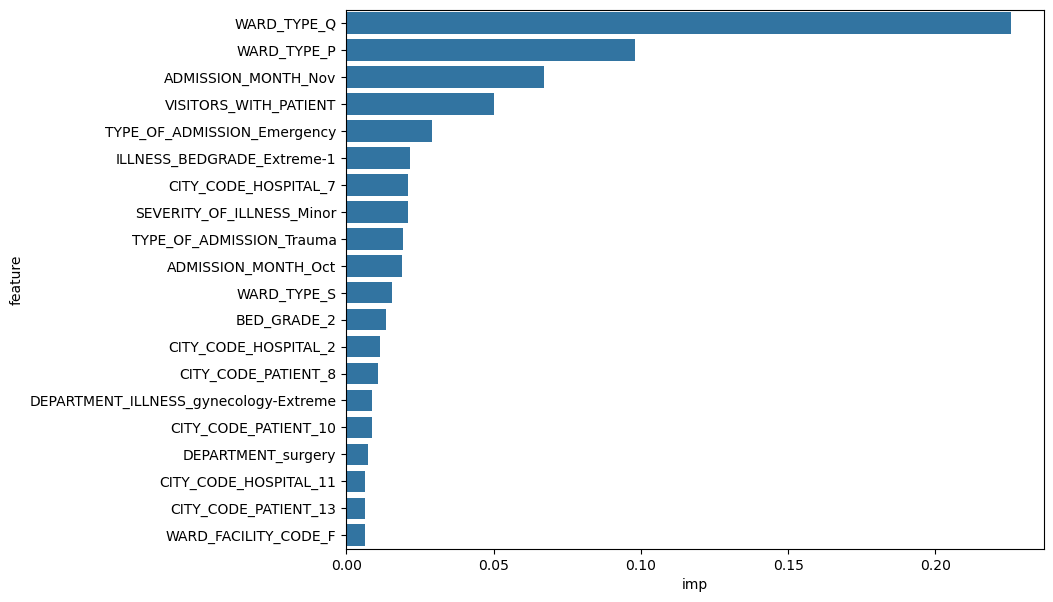

In [31]:
# Feature Importance
feat_imp = (pd.DataFrame(zip(x_train.columns,xgb_.feature_importances_),columns=['feature','imp'])
            .sort_values(by='imp',ascending=False))
display(feat_imp[:20])

plt.figure(figsize=(9,7))
sns.barplot(y='feature',x='imp',data=feat_imp[:20],orient='h')
plt.show()

In [32]:
# Selecting features with atleast 1% importance value
display(feat_imp[feat_imp['imp']>=0.01][:10])
final_features_xgb = feat_imp[feat_imp['imp']>=0.01]['feature'].values.tolist()
print(f'Total features from xgb :{len(final_features_xgb)}')
final_features_xgb[:5]

,feature,imp
30,WARD_TYPE_Q,0.225502
29,WARD_TYPE_P,0.098103
100,ADMISSION_MONTH_Nov,0.066964
1,VISITORS_WITH_PATIENT,0.050074
83,TYPE_OF_ADMISSION_Emergency,0.029200
120,ILLNESS_BEDGRADE_Extreme-1,0.021617
16,CITY_CODE_HOSPITAL_7,0.020879
87,SEVERITY_OF_ILLNESS_Minor,0.020793
84,TYPE_OF_ADMISSION_Trauma,0.019421
101,ADMISSION_MONTH_Oct,0.018822


Total features from xgb :14


['WARD_TYPE_Q',
 'WARD_TYPE_P',
 'ADMISSION_MONTH_Nov',
 'VISITORS_WITH_PATIENT',
 'TYPE_OF_ADMISSION_Emergency']

### Feature union 



In [33]:
model_features=list(set(final_features_xgb).union(set(final_features_dtree)))
print(f'Final Features from both Dtree & XGB: {str(len(model_features))}')

Final Features from both Dtree & XGB: 26


In [34]:
model_features

['ADMISSION_MONTH_Nov',
 'ADMISSION_DAY_Tue',
 'ADMISSION_DAY_Thu',
 'ILLNESS_BEDGRADE_Extreme-1',
 'AGE_41-50',
 'ADMISSION_MONTH_Oct',
 'ADMISSION_DAY_Wed',
 'VISITORS_WITH_PATIENT',
 'CITY_CODE_HOSPITAL_7',
 'WARD_TYPE_P',
 'AVAILABLE_EXTRA_ROOMS_IN_HOSPITAL',
 'AGE_71-80',
 'WARD_TYPE_Q',
 'ADMISSION_DEPOSIT',
 'AGE_31-40',
 'BED_GRADE_2',
 'TYPE_OF_ADMISSION_Trauma',
 'CITY_CODE_PATIENT_8',
 'TYPE_OF_ADMISSION_Emergency',
 'ADMISSION_DAY_Mon',
 'ADMISSION_DAY_Fri',
 'CITY_CODE_HOSPITAL_2',
 'ADMISSION_DAY_Sun',
 'ADMISSION_DAY_Sat',
 'WARD_TYPE_S',
 'SEVERITY_OF_ILLNESS_Minor']

In [35]:
# Creating pickle file to save model features 
df_final[model_features+['LOS']].to_pickle('MODEL_training_data_with_final_features.pkl')

In [36]:
import pickle 
final_feats_list = model_features+['LOS']
with open('MODEL_FEATS.pkl','wb') as F:
     pickle.dump(final_feats_list,F)

### Model Building 



In [37]:
from sklearn.model_selection import train_test_split

df_features = pd.read_pickle('MODEL_training_data_with_final_features.pkl')
print(df_features.shape)
df_features.head(3)

(236704, 27)


,ADMISSION_MONTH_Nov,ADMISSION_DAY_Tue,ADMISSION_DAY_Thu,ILLNESS_BEDGRADE_Extreme-1,AGE_41-50,ADMISSION_MONTH_Oct,ADMISSION_DAY_Wed,VISITORS_WITH_PATIENT,CITY_CODE_HOSPITAL_7,WARD_TYPE_P,AVAILABLE_EXTRA_ROOMS_IN_HOSPITAL,AGE_71-80,WARD_TYPE_Q,ADMISSION_DEPOSIT,AGE_31-40,BED_GRADE_2,TYPE_OF_ADMISSION_Trauma,CITY_CODE_PATIENT_8,TYPE_OF_ADMISSION_Emergency,ADMISSION_DAY_Mon,ADMISSION_DAY_Fri,CITY_CODE_HOSPITAL_2,ADMISSION_DAY_Sun,ADMISSION_DAY_Sat,WARD_TYPE_S,SEVERITY_OF_ILLNESS_Minor,LOS
CASE_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,1,2,0,0,3,0,0,4911,0,1,0,0,1,0,0,0,0,0,0,0,10
3,0,0,0,0,0,0,0,2,0,0,2,0,0,4745,0,1,1,0,0,0,1,0,0,0,1,0,40
4,0,0,1,0,0,0,0,2,0,0,2,0,0,7272,0,1,1,0,0,0,0,1,0,0,0,0,50


In [38]:
# Train and Test split
X = df_features.drop('LOS',axis=1)
y = df_features[['LOS']]
print(X.shape,y.shape)

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.3,stratify=y,random_state=123)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(236704, 26) (236704, 1)
(165692, 26) (165692, 1)
(71012, 26) (71012, 1)


### 1.linear Regression

In [39]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(x_train, y_train)
lr.score(x_train,y_train)

0.1833534289309301

In [40]:
preds = np.ceil(lr.predict(x_test))
rmse = np.sqrt(metrics.mean_squared_error(y_test,preds))
mae = np.sqrt(metrics.mean_absolute_error(y_test,preds))
print("RMSE: ", rmse)
print("MAE: ", mae)

RMSE:  15.212946578248154
MAE:  3.3718815848398602


### 2. Random Forest Regression 


In [41]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(x_train,y_train)
rf.score(x_train,y_train)

0.8991875137523156

In [42]:
preds = np.ceil(rf.predict(x_test))
rmse = np.sqrt(metrics.mean_squared_error(y_test,preds))
mae = np.sqrt(metrics.mean_absolute_error(y_test,preds))
print("RMSE: ", rmse)
print("MAE: ", mae)

RMSE:  14.254866520321933
MAE:  3.2462384368966073


### 3. XGB Regression

In [43]:
import xgboost as xgb

xgb_ = xgb.XGBRegressor()
xgb_.fit(x_train,y_train)
xgb_.score(x_train,y_train)

0.3966139554977417

In [46]:
preds = np.ceil(xgb_.predict(x_test))
rmse = np.sqrt(metrics.mean_squared_error(y_test,preds))
mae = np.sqrt(metrics.mean_absolute_error(y_test,preds))
print("RMSE: ", rmse)
print("MAE: ", mae)

train_ref_metrics = {}
train_ref_metrics['RMSE'] = rmse
train_ref_metrics['MAE'] = mae 

RMSE:  13.58599814894456
MAE:  3.1669589125314066


In [45]:
# saving the trained model 
booster=xgb_.get_booster()
booster.save_model('MODEL_XGB.model')


In [48]:
# saving the reference performance dict (from training)

with open('MODEL_XGB_PERFM_METRICS.pkl', 'wb') as F:
    pickle.dump(train_ref_metrics,F)